# NNDL Project - Riccardo De Vidi - 2152869

## C. Testing and benchmarks

### 1. Packages and data import

Packages import

In [ ]:
!sudo apt-get install fluidsynth > /dev/null 2>&1
!pip install pretty_midi mir_eval pyfluidsynth > /dev/null 2>&1
import pretty_midi

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import time as time

import matplotlib.pyplot as plt

Select the available device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Import generated data

In [ ]:
data = np.load("data.npz")
data = list(data.values())
print(f"{len(data)} data elements are considered")

40032 data elements are considered


In [ ]:
class ChordDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        prev_chord_bar = self.transform(self.data[idx][0]).float()
        prev_melody_bar = self.transform(self.data[idx][1]).float()
        chord_bar = self.transform(self.data[idx][2]).float()
        chord_bar = torch.cat((torch.zeros(1, 60, 16), chord_bar), dim=1)
        chord_bar = torch.cat((chord_bar, torch.zeros(1, 44, 16)), dim=1)
        return prev_melody_bar, prev_chord_bar, chord_bar

dataset = ChordDataset(data=data, transform=ToTensor())

### 2. Models

Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):

        super().__init__()

        self.cond = nn.Sequential(
            nn.Conv2d(2, 256, kernel_size=(24, 2), stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            nn.Linear(2048, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(1024, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.noise_fc_net = nn.Sequential(
            nn.Linear(100, 2048, bias=False),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=(1, 2), stride=2, bias=False), # 1x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(512, 256, (1, 2), stride=2, bias=False), # 1x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(256, 128, (1, 2), stride=2, bias=False), # 1x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(128, 1, (128, 1), stride=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, noise, cond_1, cond_2):

        # Input noise
        n = self.noise_fc_net(noise).reshape((-1, 512, 1, 2))
        # Previous bars
        cn = self.cond(torch.cat([cond_1, cond_2], dim=1)).reshape((-1, 512, 1, 2))
        # Generator
        y = torch.cat([n, cn], dim=1)
        out = self.gen(y)

        return out

Discriminator

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.prev_conv = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(24, 2), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=(1, 4), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Flatten()
        )

        self.new_conv = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=(128, 2), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=(1, 4), stride=2, bias=False),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(512*6, 1024, bias=False),
            nn.LeakyReLU(),
            nn.Linear(1024, 1024, bias=False),
            nn.LeakyReLU(),
            nn.Linear(1024, 1, bias=False)
        )

    def forward(self, prev, new):

        # Previous bar
        p = self.prev_conv(prev)
        # New or generated bar
        n = self.new_conv(new)
        # Fully connected network
        f = torch.cat([p, n], dim=1)
        out = self.fc(f)

        return out

### 3. Test

Generator, discriminator and dataloader inizialization

In [ ]:
melody_generator = Generator()
melody_generator.load_state_dict(torch.load('melody_generator.pth'))
melody_generator.to(device)
melody_generator.eval()

chord_generator = Generator()
chord_generator.load_state_dict(torch.load('chord_generator.pth'))
chord_generator.to(device)
chord_generator.eval()

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=os.cpu_count())
dataloader_iter = iter(dataloader)

Load a chord bar and a melody bar

In [ ]:
data_bars = next(dataloader_iter)
prev_melodies = data_bars[0].to(device)
prev_chords = data_bars[1].to(device)

prev_melody = prev_melodies[0].reshape(1, 1, 24, 16)
prev_chord = prev_chords[0].reshape(1, 1, 24, 16)

Generate new bars

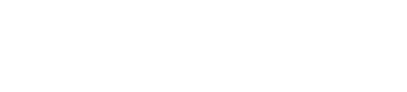

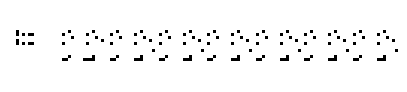

In [ ]:
melody_track = [prev_melody]
chord_track = [prev_chord]

for _ in range(7):

  noise_m = torch.rand([1, 100], device=device)
  noise_c = torch.rand([1, 100], device=device)

  new_melody = (melody_generator(noise_m, melody_track[-1], chord_track[-1]) > 0.1).float()[:, :, 60:84, :]
  new_chord = (chord_generator(noise_m, chord_track[-1], melody_track[-1]) > 0.1).float()[:, :, 60:84, :]

  melody_track.append(new_melody)
  chord_track.append(new_chord)

melody_track = [x.detach().cpu().squeeze().numpy() for x in melody_track]
chord_track = [x.detach().cpu().squeeze().numpy() for x in chord_track]

melody_track = np.concatenate(melody_track, axis=1)
chord_track = np.concatenate(chord_track, axis=1)

plt.figure(figsize=(5, 5))
plt.imshow(melody_track, cmap='binary')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(chord_track, cmap='binary')
plt.axis('off')
plt.show()

Create the corresponding midi file

In [ ]:
def boolean_matrix_to_midi(bool_matrix, output_file, bar_len_s=2.0, bar_len=16):
    """
        Converts a boolean matrix to a midi file. The generated file contains one
        channel for each level in the input.
        bool_matrix: boolean matrix to be processes
        output_file: name of the output file
        bar_len_s: duration of a bar in seconds
        bar_len: number of samples in a bar
    """

    pm = pretty_midi.PrettyMIDI()

    program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    instrument = pretty_midi.Instrument(program=program)

    step_duration = bar_len_s/bar_len

    num_steps = bool_matrix[0].shape[1]

    for matrix in bool_matrix:
        for i in range(128):
            playing = False
            start_time = 0
            for t in range(num_steps):
                current = matrix[i, t]
                previous = matrix[i, t - 1] if t > 0 else False
                if current and not previous:
                    # Note just started
                    start_time = t*step_duration
                    playing = True
                elif not current and previous:
                    # Note just ended
                    end_time = t*step_duration
                    note = pretty_midi.Note(velocity=100, pitch=i, start=start_time, end=end_time)
                    instrument.notes.append(note)
                    playing = False
            # If still playing at the end
            if playing:
                end_time = num_steps*step_duration
                note = pretty_midi.Note(velocity=100, pitch=i, start=start_time, end=end_time)
                instrument.notes.append(note)
        pm.instruments.append(instrument)

    pm.write(output_file)

In [ ]:
melody_track  = np.vstack((np.zeros((60, 16*8)), melody_track, np.zeros((44, 16*8))))
chord_track  = np.vstack((np.zeros((60, 16*8)), chord_track, np.zeros((44, 16*8))))
track = [melody_track, chord_track]
boolean_matrix_to_midi(track, "track.mid")

### 4. Pitch count and note count

In [ ]:
bench_num = 10000

# Pitch count
# Number of different pitches within a sample
# The output is a scalar for each sample
real_melody_pitch_count = []
real_chord_pitch_count = []
gen_melody_pitch_count = []
gen_chord_pitch_count = []

# Note count
# Number of used notes
# The output is a scalar for each sample
real_melody_note_count = []
real_chord_note_count = []
gen_melody_note_count = []
gen_chord_note_count = []

for _ in range(bench_num):

    data_bars = next(dataloader_iter)
    prev_melody = data_bars[0][0].to(device).reshape(1, 1, 24, 16)
    prev_chord = data_bars[1][0].to(device).reshape(1, 1, 24, 16)
    noise_m = torch.rand([1, 100], device=device)
    noise_c = torch.rand([1, 100], device=device)
    new_melody = (melody_generator(noise_m, prev_melody, prev_chord) > 0.1).float()[:, :, 60:84, :]
    new_chord = (chord_generator(noise_m, prev_chord, prev_melody) > 0.1).float()[:, :, 60:84, :]

    prev_melody = prev_melody.detach().cpu().squeeze().numpy()
    prev_chord = prev_chord.detach().cpu().squeeze().numpy()
    new_melody = new_melody.detach().cpu().squeeze().numpy()
    new_chord = new_chord.detach().cpu().squeeze().numpy()

    real_melody_pitch_count.append(np.count_nonzero(np.any(prev_melody != 0, axis=1)))
    real_chord_pitch_count.append(np.count_nonzero(np.any(prev_chord != 0, axis=1)))
    gen_melody_pitch_count.append(np.count_nonzero(np.any(new_melody != 0, axis=1)))
    gen_chord_pitch_count.append(np.count_nonzero(np.any(new_chord != 0, axis=1)))

    real_melody_note_count.append(np.sum(prev_melody))
    real_chord_note_count.append(np.sum(prev_chord))
    gen_melody_note_count.append(np.sum(new_melody))
    gen_chord_note_count.append(np.sum(new_chord))

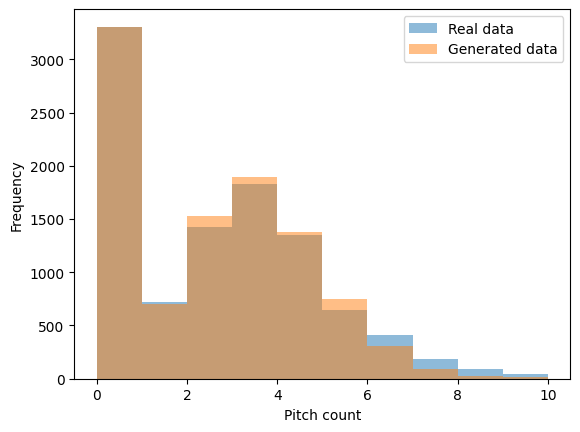

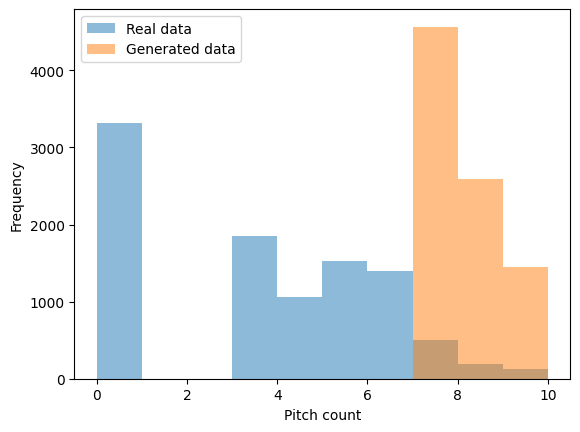

In [ ]:
plt.hist(real_melody_pitch_count, bins=np.arange(0, 11, 1), alpha=0.5, label='Real data')
plt.hist(gen_melody_pitch_count, bins=np.arange(0, 11, 1), alpha=0.5, label='Generated data')
plt.title('Melody pitch count')
plt.xlabel('Pitch count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(real_chord_pitch_count, bins=np.arange(0, 11, 1), alpha=0.5, label='Real data')
plt.hist(gen_chord_pitch_count, bins=np.arange(0, 11, 1), alpha=0.5, label='Generated data')
plt.title('Chord pitch count')
plt.xlabel('Pitch count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

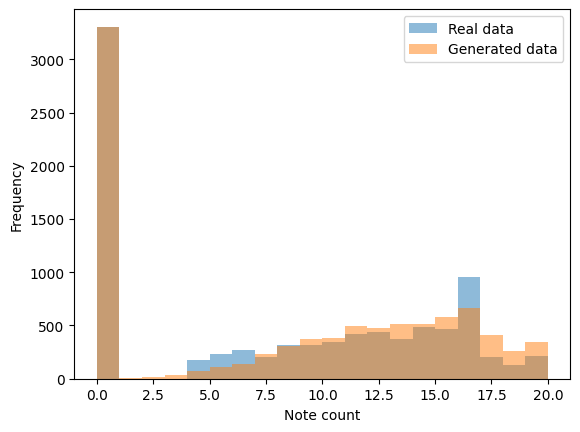

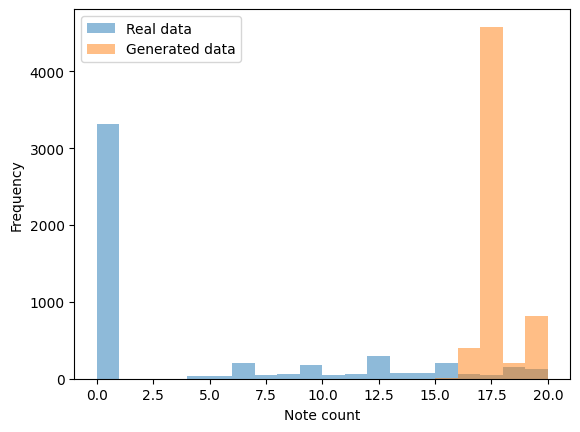

In [ ]:
plt.hist(real_melody_note_count, bins=np.arange(0, 21, 1), alpha=0.5, label='Real data')
plt.hist(gen_melody_note_count, bins=np.arange(0, 21, 1), alpha=0.5, label='Generated data')
plt.title('Melody note count')
plt.xlabel('Note count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(real_chord_note_count, bins=np.arange(0, 21, 1), alpha=0.5, label='Real data')
plt.hist(gen_chord_note_count, bins=np.arange(0, 21, 1), alpha=0.5, label='Generated data')
plt.title('Chord note count')
plt.xlabel('Note count')
plt.ylabel('Frequency')
plt.legend()
plt.show()